we will use auto ARIMA for time series analysis.

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.8 MB/s eta 0:00:00a 0:00:01m


In [3]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.7 MB/s eta 0:00:00a 0:00:010m


In [4]:
# import libraries
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.random.seed(13)

loading the dataset.

In [5]:
df = pd.read_csv('/home/aaranyak/Documents/ml_projects/ml_projects/NIFTY-50 STOCK MARKET(BAJAJFINSV)/BAJAJFINSV.csv')
df.set_index('Date',drop=False,inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


plotting the target variable VWAP over time.

<Axes: xlabel='Date'>

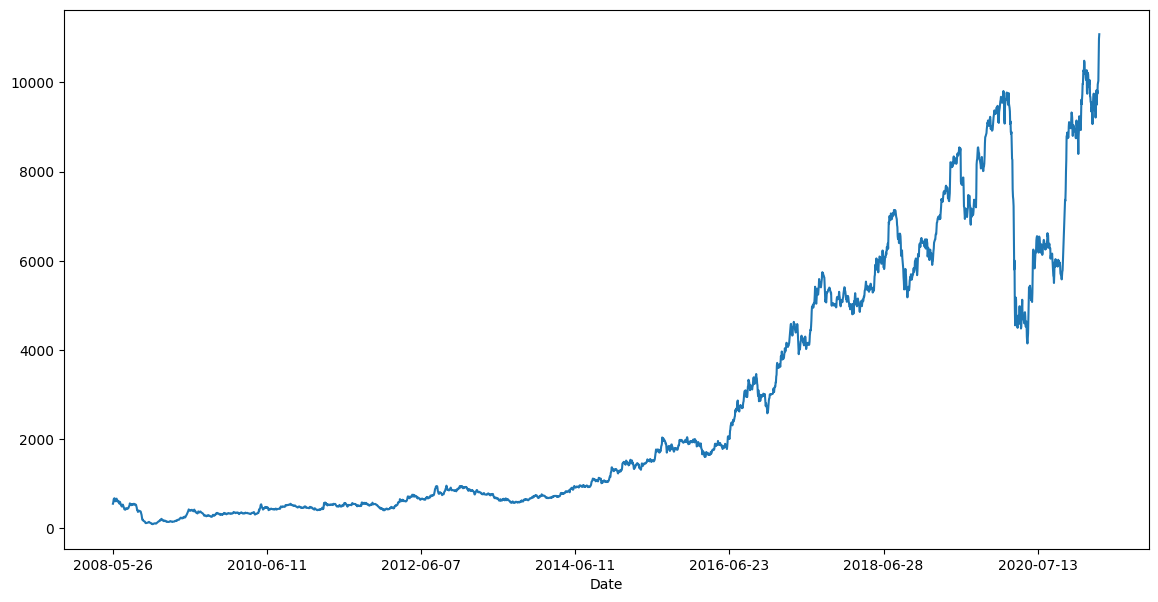

In [6]:
df.VWAP.plot(figsize=(14,7))

Feature Engineering

In [11]:
import pandas as pd
import numpy as np

# Assuming you have already loaded your data into the df DataFrame

# Convert the "Date" column to datetime if it's not already in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Set the "Date" column as the index
df.set_index("Date", drop=False, inplace=True)

lag_features = ['High', 'Low', 'Volume', 'Turnover', 'Trades']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=1)  # min_periods changed from 0 to 1
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=1)  # min_periods changed from 0 to 1
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=1)  # min_periods changed from 0 to 1

df_mean_3d = df_rolled_3d.mean().shift(1)
df_mean_7d = df_rolled_7d.mean().shift(1)
df_mean_30d = df_rolled_30d.mean().shift(1)

df_std_3d = df_rolled_3d.std().shift(1)
df_std_7d = df_rolled_7d.std().shift(1)
df_std_30d = df_rolled_30d.std().shift(1)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

# Handle NaN values using other strategies if needed
# df.fillna(method='ffill', inplace=True)  # Forward fill NaN values

# Display the head of the DataFrame to check the results
print(df.head())


                 Date      Symbol  ... Trades_std_lag7  Trades_std_lag30
Date                               ...                                  
2008-05-26 2008-05-26  BAJAJFINSV  ...             NaN               NaN
2008-05-27 2008-05-27  BAJAJFINSV  ...             NaN               NaN
2008-05-28 2008-05-28  BAJAJFINSV  ...             NaN               NaN
2008-05-29 2008-05-29  BAJAJFINSV  ...             NaN               NaN
2008-05-30 2008-05-30  BAJAJFINSV  ...             NaN               NaN

[5 rows x 45 columns]


In [13]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.isocalendar().week  # Use isocalendar().week instead of week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558,619.000,619.0000,619.0000,NaN,NaN,NaN,501.000000,501.000,501.000,NaN,NaN,NaN,3145446.0,3145446.00,3145446.00,NaN,NaN,NaN,1.726368e+14,1.726368e+14,1.726368e+14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689,614.975,614.9750,614.9750,5.692210,5.692210,5.692210,496.050000,496.050,496.050,7.000357,7.000357,7.000357,3747295.0,3747295.00,3747295.00,851143.018301,851143.018301,851143.018301,2.107369e+14,2.107369e+14,2.107369e+14,5.388164e+13,5.388164e+13,5.388164e+13,NaN,NaN,NaN,NaN,NaN,NaN,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225,631.850,631.8500,631.8500,29.504195,29.504195,29.504195,518.700000,518.700,518.700,39.542003,39.542003,39.542003,4027783.0,4027783.00,4027783.00,773461.552524,773461.552524,773461.552524,2.350756e+14,2.350756e+14,2.350756e+14,5.682195e+13,5.682195e+13,5.682195e+13,NaN,NaN,NaN,NaN,NaN,NaN,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514,659.850,649.6375,649.6375,46.293601,42.964081,42.964081,554.366667,541.025,541.025,59.042386,55.099932,55.099932,4486735.0,4151412.75,4151412.75,123703.660710,678207.767450,678207.767450,2.769607e+14,2.508797e+14,2.508797e+14,2.541759e+13,5.613884e+13,5.613884e+13,NaN,NaN,NaN,NaN,NaN,NaN,5,22,30,4


splitting the data into train and validation along with other features.

In [14]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

Now we will use auto ARIMA with the exogenous features - ARIMAX.

In [17]:
import pandas as pd
from pmdarima import auto_arima

# Assuming you have already loaded your df_train and df_valid DataFrames

# Define the list of exogenous feature names
exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

# Fit the auto_arima model
model = auto_arima(df_train['VWAP'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['VWAP'], exogenous=df_train[exogenous_features])

# Make forecasts
forecast, conf_int = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features], return_conf_int=True)

# Create a DataFrame to store the forecasts and confidence intervals
forecast_df = pd.DataFrame({'Forecast_ARIMAX': forecast, 'Lower_CI': conf_int[:, 0], 'Upper_CI': conf_int[:, 1]}, index=df_valid.index)

# Merge the forecast DataFrame with the validation DataFrame
df_valid = pd.concat([df_valid, forecast_df], axis=1)

# Print the updated DataFrame with forecasts and confidence intervals
print(df_valid)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=28269.314, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=27879.000, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=27581.376, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=27503.456, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=27415.022, Time=0.19 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=27365.988, Time=0.23 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.55 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=27367.989, Time=0.34 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 4.038 seconds
                 Date      Symbol  ...       Lower_CI       Upper_CI
Date                               ...                              
2019-01-01 2019-01-01  BAJAJF

/home/aaranyak/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aaranyak/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

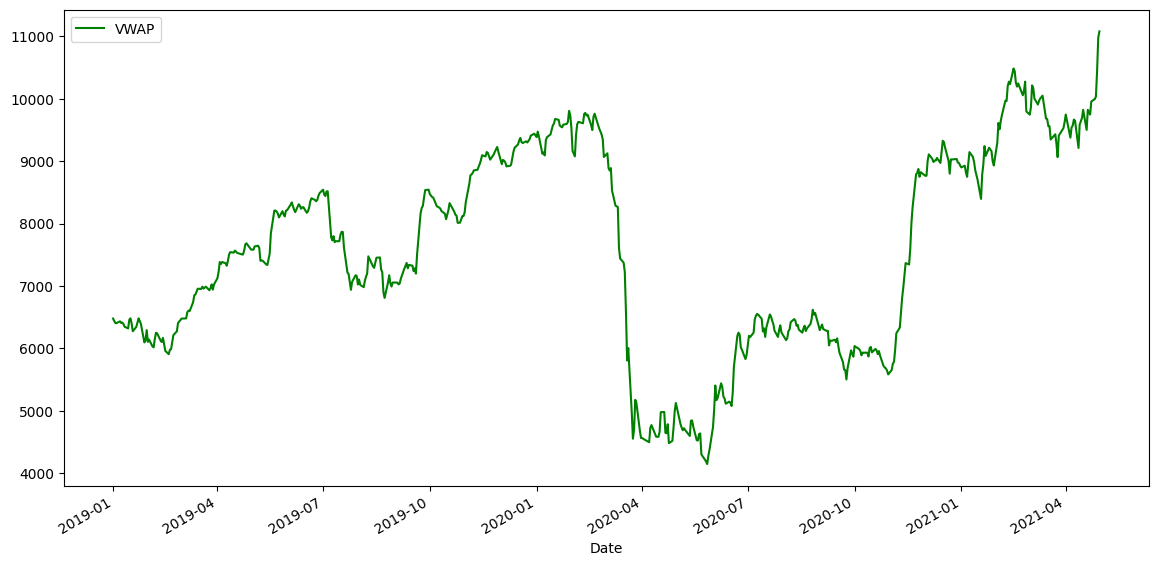

In [24]:
df_valid[['VWAP']].plot(figsize=(14,7),color='green')

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Check for NaN values in the DataFrame
if df_valid['VWAP'].isnull().any() or df_valid['Forecast_ARIMAX'].isnull().any():
    print("Warning: NaN values detected in 'VWAP' or 'Forecast_ARIMAX' columns.")
else:
    # Calculate RMSE
    rmse_arimax = np.sqrt(mean_squared_error(df_valid['VWAP'], df_valid['Forecast_ARIMAX']))

    # Print RMSE
    print("RMSE of auto ARIMAX:", rmse_arimax)



I think the error above is occuring because I concatenated both the parameters into one df_valid.